In [1]:
#Importing necessary Libraries
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow_addons as tfa
from keras.models import Sequential

In [2]:
TRAIN_PATH = "../input/pneumonia-classification-challenge/pneumonia_dataset/pneumonia_dataset/train"
#TRAIN_PATH = "../input/pneumonia-classification-challenge/pneumonia_dataset_new/pneumonia_dataset_new"
TEST_PATH = "../input/pneumonia-classification-challenge/pneumonia_dataset/pneumonia_dataset/test"

BATCH_SIZE = 32
HEIGHT,WIDTH = 224,224
CHANNELS = 3
NUM_CLASSES = 2
SEED = 143

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2, 
    zoom_range = 0.2,
    validation_split=0.2
   )

train_ds = train_datagen.flow_from_directory(
                             TRAIN_PATH,
                             target_size = (HEIGHT,WIDTH),
                             batch_size = BATCH_SIZE,
                             class_mode = "binary",
                             shuffle = True,
                             seed = SEED,
                             subset = "training",
                             color_mode='rgb'
                            )
val_ds = train_datagen.flow_from_directory(
                             TRAIN_PATH,
                             target_size = (HEIGHT,WIDTH),
                             batch_size = BATCH_SIZE,
                             class_mode = "binary",
                             shuffle = True,
                             seed = SEED,
                             subset = "validation",
                             color_mode='rgb'
                            )

test_df = pd.read_csv("../input/pneumonia-classification-challenge/pneumonia_dataset/pneumonia_dataset/test.csv")
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
   )
test_ds = test_datagen.flow_from_dataframe(
                      test_df,
                      directory = TEST_PATH,
                      x_col = "filename",
                      y_col = "filename",
                      target_size = (HEIGHT,WIDTH),
                      shuffle = False,
                      batch_size = BATCH_SIZE
                       )


C_PNEUMONIA = len(tf.io.gfile.glob(TRAIN_PATH + "/pneumonia/*"))
C_NORMAL = len(tf.io.gfile.glob(TRAIN_PATH + "/normal/*"))
C_TOTAL = C_PNEUMONIA + C_NORMAL

weight_0 = (1 / C_NORMAL)*(C_TOTAL)/2.0 
weight_1 = (1 / C_PNEUMONIA)*(C_TOTAL)/2.0
CLASS_WEIGHT = {
                 0: weight_0, 
                 1: weight_1
               }

classes_dict = train_ds.class_indices
print(classes_dict)
print(CLASS_WEIGHT)

Found 1940 images belonging to 2 classes.
Found 485 images belonging to 2 classes.
Found 606 validated image filenames belonging to 606 classes.
{'normal': 0, 'pneumonia': 1}
{0: 0.947265625, 1: 1.0589519650655022}


Text(0, 0.5, 'Number of Images present')

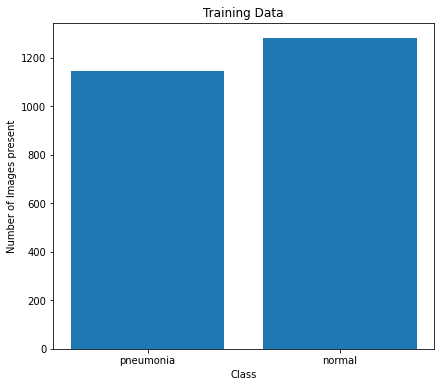

In [4]:
path_train_ls = os.listdir(TRAIN_PATH)
num_train_ls = [len(os.listdir(os.path.join(TRAIN_PATH,folder))) for folder in path_train_ls]


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.bar(path_train_ls,num_train_ls)
plt.title("Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images present")

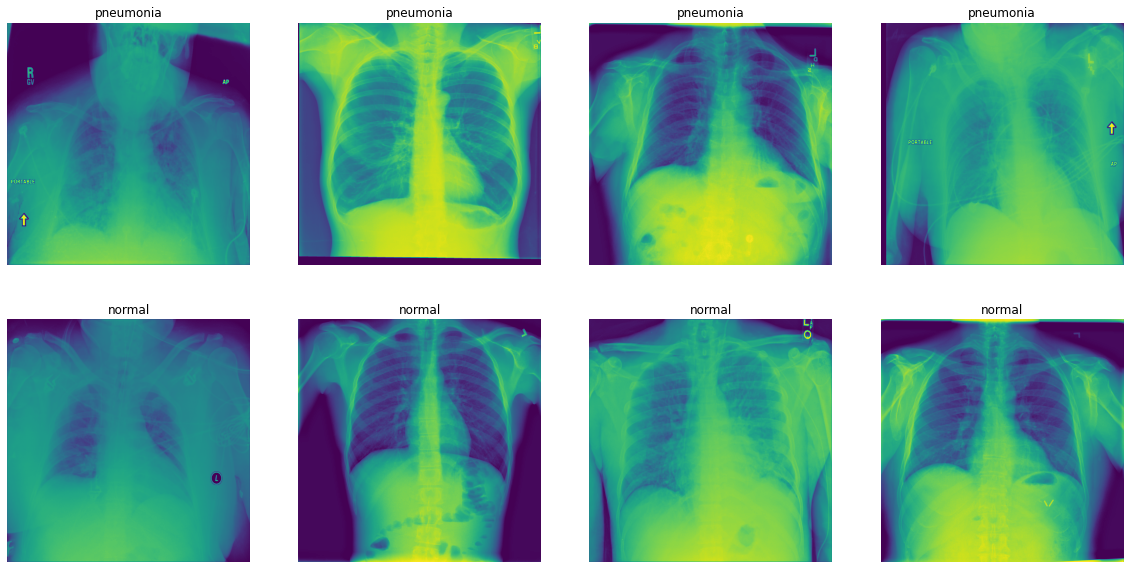

In [5]:
plt.figure(figsize=(20,10))

for i,folder in enumerate(os.listdir(TRAIN_PATH)):
    path = os.path.join(TRAIN_PATH,folder)
    img_ls = os.listdir(path)
    for j,im_name in enumerate(img_ls[:4]):
        plt.subplot(2,4,4*i+j+1)
        img_path = os.path.join(path,im_name)
        img = PIL.Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(folder)

In [6]:
model = tf.keras.applications.DenseNet121(weights= "imagenet",
                                    include_top=False,
                                    input_shape=(HEIGHT,WIDTH,CHANNELS), pooling="avg")
predictions = tf.keras.layers.Dense(14, activation='sigmoid', name='predictions')(model.output)
model = tf.keras.Model(inputs=model.input, outputs=predictions)   
model.load_weights("../input/pneumonia-classification-challenge/pretrained.h5")
model = tf.keras.Model(model.input, model.layers[-2].output) 
x = tf.keras.layers.Dense(512, activation = "relu")(model.output)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.Dense(64, activation = "relu")(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid", dtype = tf.float32)(x)
chxnet = tf.keras.Model(model.input,outputs)

for layer in chxnet.layers[:-15]:
        layer.trainble = False
        
pretrained_models = {
        0 : chxnet,
        1 : tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=[HEIGHT,WIDTH, 3]),
        2 : tf.keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=[HEIGHT,WIDTH, 3]),
        3 : tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',input_shape=[HEIGHT,WIDTH, 3]), 
    }

87916544/87910968 [==============================] - 1s 0us/step


In [7]:
def create_model(model_id):
    inputs = tf.keras.Input(shape=(HEIGHT,WIDTH, 3))
    if model_id == 0:
        outputs = pretrained_models[model_id](inputs)
        model = tf.keras.Model(inputs,outputs)
        return model
    else:
        pretrained = pretrained_models[model_id]
        x = pretrained(inputs)
        x = GlobalAveragePooling2D() (x)
        x = Dense(512, activation="relu") (x)
        x = BatchNormalization() (x)
        x = Dropout(0.6) (x)
        x = Dense(128, activation="relu") (x)
        x = BatchNormalization() (x)
        x = Dropout(0.4) (x)
        x = Dense(64,activation="relu") (x)
        x = BatchNormalization() (x)
        x = Dropout(0.3) (x)
        outputs = Dense(1,activation="sigmoid") (x)
        
        model = tf.keras.Model(inputs, outputs)
        return model
    
model = create_model(0)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_2 (Functional)         (None, 1)                 7636289   
Total params: 7,636,289
Trainable params: 7,552,641
Non-trainable params: 83,648
_________________________________________________________________


In [8]:
def compile_model(model, lr=0.001):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    loss = "binary_crossentropy"
    
    metrics = [
       'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [9]:
METRIC = "val_accuracy"

LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr

def create_callbacks(model_id):
    
    cpk_path = f'./best_model_{model_id}.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor= METRIC,
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= METRIC,
        mode='max',
        factor=0.1,
        patience=1,
        verbose=1
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= METRIC,
        mode='max',
        patience=10, 
        verbose=1
    )
    
    lrscheduler = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    
    callbacks = [checkpoint, reducelr , earlystop]         
    
    return callbacks

In [10]:
EPOCHS= 20
VERBOSE =1
history = {}
predictions = {}


for i in range(len(pretrained_models)):
    tf.keras.backend.clear_session()

    with tf.device('/device:GPU:0'):
    
        model = create_model(i)
        model = compile_model(model,lr=0.001)
   
        callbacks = create_callbacks(i)
        
        history[i] = model.fit(train_ds, 
                            epochs=EPOCHS,
                            callbacks=callbacks,
                            validation_data = val_ds,
                            verbose=VERBOSE
                           )
        
        MODEL_PATH = f"./best_model_{i}.h5"
        model = tf.keras.models.load_model(MODEL_PATH)
        predictions[i] = model.predict(test_ds)

Epoch 1/20
61/61 [==============================] - 125s 2s/step - loss: 0.6667 - accuracy: 0.5893 - precision: 0.5729 - recall: 0.4729 - val_loss: 0.5641 - val_accuracy: 0.7175 - val_precision: 0.7644 - val_recall: 0.5808

Epoch 00001: val_accuracy improved from -inf to 0.71753, saving model to ./best_model_0.h5
Epoch 2/20
61/61 [==============================] - 66s 1s/step - loss: 0.5809 - accuracy: 0.7215 - precision: 0.6903 - recall: 0.7364 - val_loss: 0.5650 - val_accuracy: 0.7216 - val_precision: 0.7937 - val_recall: 0.5546

Epoch 00002: val_accuracy improved from 0.71753 to 0.72165, saving model to ./best_model_0.h5
Epoch 3/20
61/61 [==============================] - 65s 1s/step - loss: 0.5635 - accuracy: 0.7413 - precision: 0.7077 - recall: 0.7485 - val_loss: 0.6120 - val_accuracy: 0.7010 - val_precision: 0.8231 - val_recall: 0.4672

Epoch 00003: val_accuracy did not improve from 0.72165

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/

RuntimeError: Unable to create link (name already exists)

In [11]:
#pred_ls = [classes_dict[np.argmax(i)] for i in pred]
x = tf.io.gfile.glob("./*.h5")
pred = 0
for i in range(len(x)):
    pred += predictions[i]/len(x)
    
pred_ls = ['normal' if i < 0.5 else 'pneumonia' for i in pred]

classes_dict = {0 : 'normal', 1 : 'pneumonia'}
test_df["label"] = pred_ls
test_df.to_csv("submission.csv",index = False)
print(test_df["label"].value_counts())
test_df.head()

KeyError: 3

In [12]:
for i in range(len(x)):
    pred = predictions[i]
    pred_ls = ['normal' if i < 0.5 else 'pneumonia' for i in pred]
    test_df = pd.read_csv("../input/pneumonia-classification-challenge/pneumonia_dataset/pneumonia_dataset/test.csv")
    test_df["label"] = pred_ls
    test_df.to_csv(f"submission{i}.csv",index = False)

KeyError: 3